# X3 Denoising

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py as h5
import torch as th

# Download the data from GDrive [file1](https://drive.google.com/file/d/1rQZwNN9HC_3uyd3JRpBB2cY10vEYVM2H/view?usp=drivesdk)
# Download the data from GDrive [file2](https://drive.google.com/file/d/12yZqhx6yxLrty9seXL8V5yueQ5YPUr-1/view?usp=drivesdk)

In [6]:
file_path = '/mnt/data/datascience_miniprojects/03_denoising/25815436/SrTiO3_Low_mag_Low_angle_Low_dose.npy'
data = np.load(file_path)
print(f"Data shape: {data.shape}")
ds = data.shape
data3d = data.reshape(ds[0]*ds[1], ds[2], ds[3])
print(f"Data3d shape: {data3d.shape}")

Data shape: (96, 106, 64, 64)
Data3d shape: (10176, 64, 64)


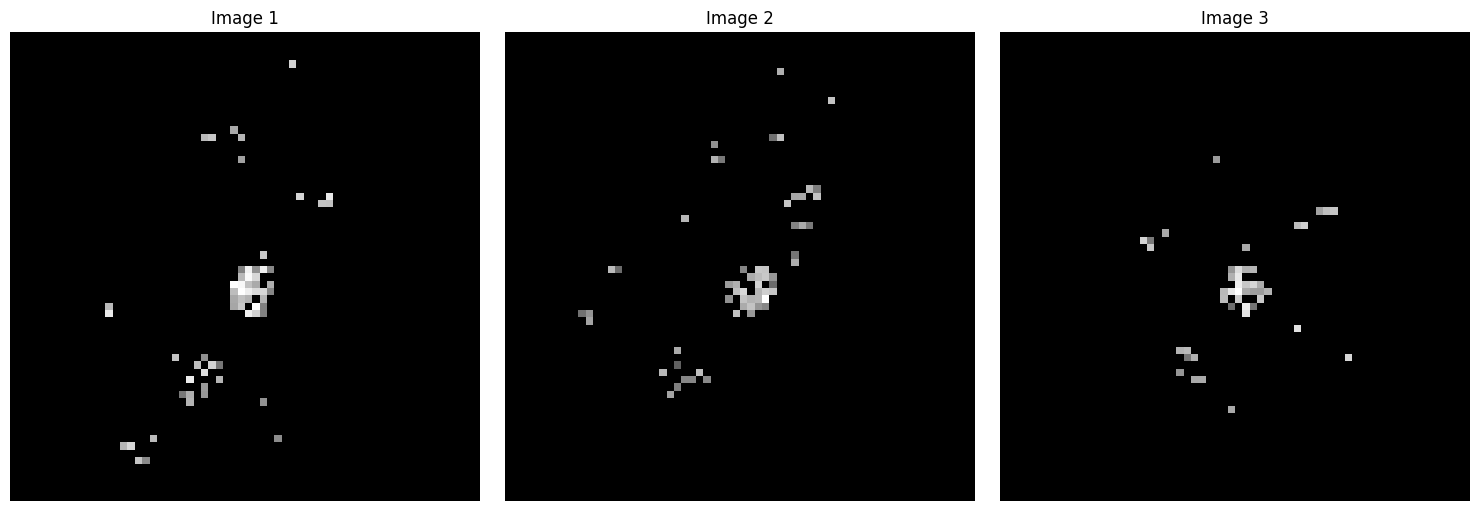

In [7]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(data3d[i+1000]**0.25, cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Training loop
num_epochs = 3
batch_size = 32

data3dt = th.from_numpy(data3d).float().unsqueeze(1).cuda()
data3dt -= data3dt.min()
data3dt /= data3dt.max()